# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# Import needed packges
import os
import cv2
import random
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

print("Loading data...")

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("Loading data is complete.")

Loading data...
Loading data is complete.


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Dataset statistics...


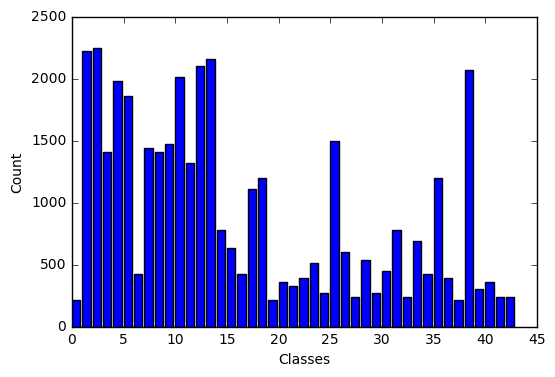

Number of training examples = 39209


In [4]:
print('Dataset statistics...')

# Plot the count of each sign
%matplotlib inline
_class, inputs_per_class = np.unique(y_train, return_counts=True)
max_inputs = np.max(inputs_per_class)
plt.bar(_class, inputs_per_class)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

# Number of training examples
n_train = len(X_train)
print("Number of training examples =", n_train)

Data visualization...


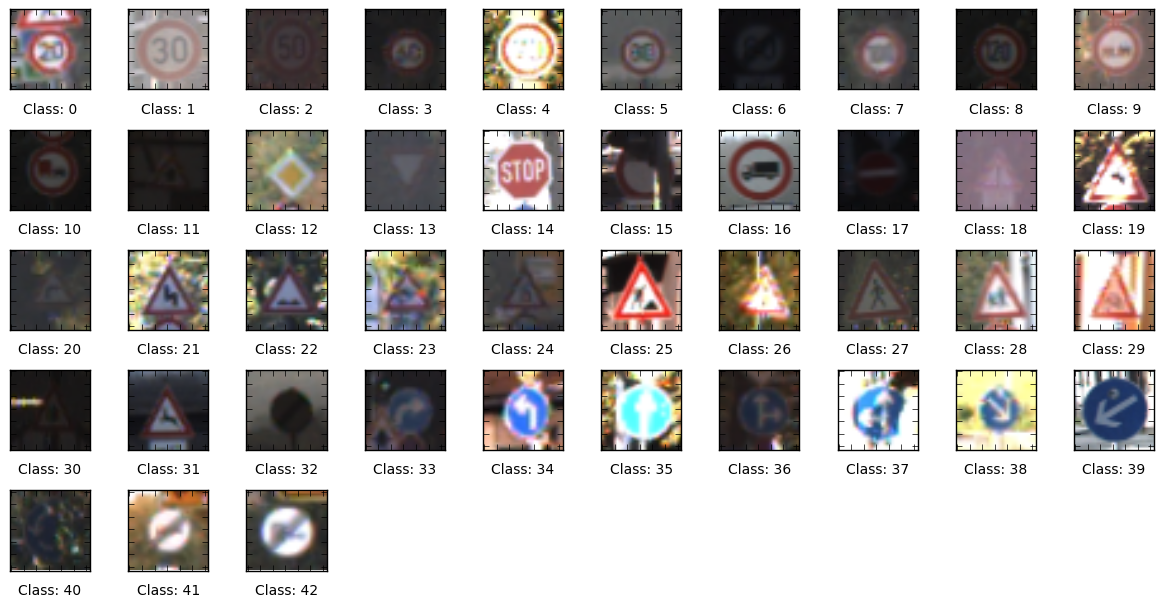

In [7]:
print ('Data visualization...')

# Plot the signs
train_features = np.array(X_train)
train_labels = np.array(y_train)

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=.5)
for i in range(n_classes):
    for label in range(len(train_labels)):
        if (i == train_labels[label]):
            ax = plt.subplot(10, 10, i+1)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            
            plt.imshow(train_features[label])
            plt.xlabel("Class: {}".format(train_labels[label]))
            break
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

* I noted that some classes has small number fo examples in the training data. So for these classes, I generated additional data by rotating the images by uniform random angles between 0 and 20 degree.

* Also I normalized the features values from uint 0-255 to float between 0.0 and 1.0 in order to reduce the variance in the data

In [5]:
# Generate additional data
def rotate_image(image):
    # This function rotate the image to generate a new image.
    # Random uniform distribution is used to generate rotation angle
    angle_range = 20
    angle_rotation = np.random.uniform(angle_range) - angle_range / 2
    rows, cols, ch = image.shape    
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle_rotation, 1)
        
    image = cv2.warpAffine(image, rotation_matrix, (cols,rows))
    
    return image

print('Generating additional data...')
for i in _class:
    ratio = min(int(max_inputs / inputs_per_class[i]), 10)
    if (ratio > 1):
        new_X_train = []
        new_y_train = []
        mask = np.where(y_train == i)
        
        for j in range(ratio):
            for X in X_train[mask]:
                new_X_train.append(rotate_image(X))
                new_y_train.append(i)
        
        X_train = np.append(X_train, new_X_train, axis=0)
        y_train = np.append(y_train, new_y_train, axis=0)
print('Generating additional data is done')

Generating additional data...
Generating additional data is done


In [6]:
# Normalize train and test features
print('Normalizing features...')
X_train = X_train / 255.
X_test = X_test / 255.
print('Normalizing features is done')

Normalizing features...
Normalizing features is done


Modified dataset statistics...


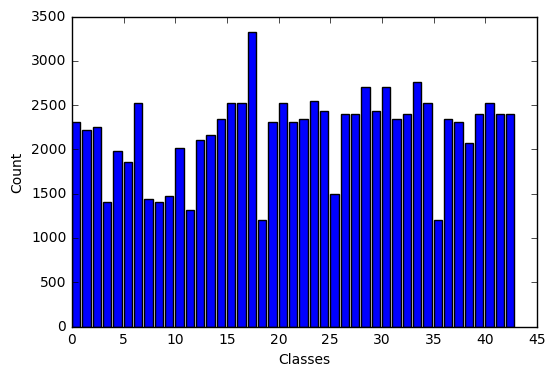

Number of training examples (after addition) = 94616


In [7]:
# Plot the count of each sign for modified data set
print('Modified dataset statistics...')
_class, inputs_per_class = np.unique(y_train, return_counts=True)
max_inputs = np.max(inputs_per_class)
plt.bar(_class, inputs_per_class)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

# Number of new of training examples
n_train = len(X_train)
print("Number of training examples (after addition) =", n_train)

In [8]:
# Split the data into training/validation sets
from sklearn.cross_validation import train_test_split
from math import ceil

def train_validation_split(X, y):
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=832289)
    return X_tr, X_val, y_tr, y_val

def batches(X, y, batch_size):
    # https://carnd-forums.udacity.com/questions/15695890/batching
    # Number of batches includes a final "rest" batch
    # if division is not exact
    n = int(ceil(len(X) / batch_size))
    for k in range(n): # for k in sample(range(n), n): # Output batches in random order
        a = k * batch_size
        b = a + batch_size
        yield (k, X[a:b], y[a:b])

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

**Set traning and validation data**
* Validation and training data was set up with split 80/20 via sklearn's train_test_split function. I decided to do the split process each time the epoch is started in order to randomize the data for traning process.
* Also I used the function inspired by Tensorflow lab (https://carnd-forums.udacity.com/questions/15695890/batching)

**Generating additional data**
* I noted that some classes has small number fo examples in the training data. So for these classes, I generated additional data by rotating the images by uniform random angles.
* The additional data has been generated in order to balance the number of training data in each class and reduce the bias the network could have . Also, it will give more data to the network.

**Randomizing Data**

New randomization and split is done each time the epoch is started to randomize the data

In [9]:
# Define network layers
from tensorflow.contrib.layers import flatten

def weight_variable(shape):
    # Initialize bias with 0.1 (positive initial) to avoid dead neurons
    # https://www.tensorflow.org/tutorials/mnist/pros/
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    # Initialize bias with 0.1 (positive initial) to avoid dead neurons
    # https://www.tensorflow.org/tutorials/mnist/pros/
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x

def relu(x):
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def dropout(x, keep_prob = 0.5):
    return tf.nn.dropout(x, keep_prob)
    
def TSNet(x):
    strides = 1
    
    # -------------- Layer 1 --------------
    # Convolutional. Input = 32x32x3. Output = 32x32x1.
    depth = 1
    depth1 = 3
    W_conv1 = weight_variable([1, 1, depth1, depth])
    b_conv1 = bias_variable([depth])
    conv1 = conv2d(x, W_conv1, b_conv1, strides)
    conv1 = relu(conv1)
    
    # -------------- Layer 2 --------------
    # Convolutional. Input = 32x32x1. Output = 32x32x32.
    depth1 = 1
    depth2 = 32
    W_conv2 = weight_variable([5, 5, depth1, depth2])
    b_conv2 = bias_variable([depth2])
    conv2 = conv2d(conv1, W_conv2, b_conv2, strides)
    conv2 = relu(conv2)
    
    # -------------- Layer 3 --------------
    # Convolutional. Input = 32x32x32. Output = 32x32x32
    depth3 = 32
    W_conv3 = weight_variable([5, 5, depth2, depth3])
    b_conv3 = bias_variable([depth3])
    conv3 = conv2d(conv2, W_conv3, b_conv3, strides)
    conv3 = relu(conv3)

    # -------------- Layer 4 --------------
    # Convolutional. Input = 32x32x32. Output = 16x16x32
    conv4 = maxpool2d(conv3)

    # -------------- Layer 5 --------------
    # Convolutional. Input = 16x16x32. Output = 16x16x32
    conv5 = dropout(conv4, keep_prob)
    
    # -------------- Layer 6 --------------
    # Convolutional. Input = 16x16x32. Output = 16x16x16
    depth3 = 16
    W_conv6 = weight_variable([5, 5, depth2, depth3])
    b_conv6 = bias_variable([depth3])
    conv6 = conv2d(conv5, W_conv6, b_conv6, strides)
    conv6 = relu(conv6)
        
    # -------------- Layer 7 --------------
    # Convolutional. Input = 16x16x16. Output = 16x16x16
    depth7 = 16
    W_conv7 = weight_variable([5, 5, depth3, depth7])
    b_conv7 = bias_variable([depth7])
    conv7 = conv2d(conv6, W_conv7, b_conv7, strides)
    conv7 = relu(conv7)

    # -------------- Layer 8 --------------    
    # Convolutional. Input = 16x16x16. Output = 8x8x16
    conv8 = maxpool2d(conv7)
    
    # -------------- Layer 9 --------------
    # Convolutional. Input = 8x8x16. Output = 8x8x16
    conv9 = dropout(conv8, keep_prob)
        
    # -------------- Layer 10 --------------
    # Flatten. Input = 8x8x16. Output = 1204.
    width1 = 1024
    fc1 = flatten(conv9)
    fc1_flat = tf.reshape(fc1, [-1, width1])
    
    # -------------- Layer 11 --------------
    # Fully connected. Input = 1204. Output = 120
    width2 = 120
    W_fc2 = weight_variable([width1, width2]) 
    b_fc2 = bias_variable([width2])
    fc2 = tf.add(tf.matmul(fc1_flat, W_fc2), b_fc2)
    fc2 = relu(fc2)
    
    # -------------- Layer 12 --------------
    # Fully connected. Input = 120. Output = 84
    width3 = 84
    W_fc3 = weight_variable([width2, width3])
    b_fc3 = bias_variable([width3])
    fc3 = tf.add(tf.matmul(fc2, W_fc3), b_fc3)
    fc3 = relu(fc3)
    
    # -------------- Layer 13 --------------
    # Fully connected. Input = 120. Output = 84
    fc3 = dropout(fc3, keep_prob)
    
    # -------------- Layer 14 --------------
    # Fully connected. Input = 84. Output = 43
    W_fc4 = weight_variable([width3, n_logits])
    b_fc4 = bias_variable([n_logits])
    fc4 = tf.add(tf.matmul(fc3, W_fc4), b_fc4)

    logits = fc4
    return logits

print("Architecture design is completed")

Architecture design is completed


In [10]:
batch_size = 128
rate = 0.001
n_logits = 43

keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int32, [None])
one_hot_y = tf.one_hot(y, n_logits)

logits = TSNet(x)

# Define loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

In [11]:
# Evaluation & Prediction
prediction = tf.nn.softmax(logits)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

**Hyperparameters**
- Stride: 1 with SAME padding
- Pooling: Max pooling over 2x2 blocks
- Learning Rate: 0.001
- Batch Size: 128
- Patch Size: 1x1 for first convolutional layer, 5x5 for other convolutional layers

**Traning**
I started with LeNet acrhitecture from course with inspiring of Deep MNIST for Expert (https://www.tensorflow.org/tutorials/mnist/pros/) of Tensorflow website. I got validation accuracy 0.96 with initial architecture which was good start!

I started to search and look for ways to improve my architecture in order to get more accuracy for validation and also testing. Tested with various number of conv layers, maxpool layers, and different paramters.

Also I converted images to grayscale but didn't get significant difference and finally decided to let first layer of network decide which channel(color) to use. (LINK TO ARTCLE)

Also I normalized the features values from uint 0-255 to float between 0.0 and 1.0 in order to reduce the variance in the data and help to converge the network in fewer epoches

Before applying dropout, my architecture converge after more epochs but after applying two dropout layers, I've got 0.995 validation accuracy in epoch 16. the drop layers avoid overfitting.

This the acrhitecture:
- Layer 1 : Type: Convolutional(+relu) - Patch Size: 1x1 - Input: 32x32x3 - Output: 32x32x1
- Layer 2 : Type: Convolutional(+relu) - Patch Size: 5x5 - Input: 32x32x1 - Output: 32x32x32
- Layer 3 : Type: Convolutional(+relu) - Patch Size: 5x5 - Input: 32x32x32 - Output: 32x32x32
- Layer 4 : Type: Maxpool - Stride: 2 - Input: 32x32x32 - Output: 16x16x32
- Layer 5 : Type: Dropout - Keep Prob: 0.5 for traing and 1.0 for validation/testing
- Layer 6 : Type: Convolutional(+relu) - Patch Size: 5x5 - Input: 16x16x32 - Output: 16x16x16
- Layer 7 : Type: Convolutional(+relu) - Patch Size: 5x5 - Input: 16x16x16 - Output: 16x16x16
- Layer 8 : Type: Maxpool - Stride: 2 - Input: 16x16x16 - Output: 8x8x16
- Layer 9 : Type: Dropout - Keep Prob: 0.5 for traing and 1.0 for validation/testing
- Layer 10: Type: Fully Connected(+relu) - Flattening - Input: 8x8x16 - Output: 1024
- Layer 11: Type: Fully Connected(+relu) - Input: 1024 - Output: 120
- Layer 12: Type: Fully Connected(+relu) - Input: 120 - Output: 84
- Layer 13: Type: Dropout - Keep Prob: 0.5 for traing and 1.0 for validation/testing
- Layer 14: Type: Fully Connected(+relu) - Input: 84 - Output: 43

In [13]:
file = 'trained_model.ckpt'
saver = tf.train.Saver()

n_epochs = 50

init = tf.global_variables_initializer()
with tf.Session() as sess:
    # Initialize all the Variables
    sess.run(init)
    
    print("Training...")
    
    for epoch in range(n_epochs):
        # Split traing and validation data
        X_tr, X_val, y_tr, y_val = train_validation_split(X_train, y_train)
        
        # Train
        for (k, batch_X, batch_y) in batches(X_tr, y_tr, batch_size):
            sess.run(training_operation, feed_dict={x: batch_X, y: batch_y, keep_prob:0.5})

        # Evaluate
        validation_accuracy = []
        for (k, batch_X, batch_y) in batches(X_val, y_val, batch_size):
            v_accuracy = sess.run(accuracy_operation, feed_dict={x: batch_X, y: batch_y, keep_prob:1.0})
            validation_accuracy.append(v_accuracy)
        validation_accuracy = np.mean(validation_accuracy)
        
        print('Epoch {:<3} - Validation Accuracy: {}'.format(epoch + 1, validation_accuracy))
        
    # Save the trained model
    saver.save(sess, file)
    print("Train model is saved")
    
print("Training is completed")

Training...
Epoch 1   - Validation Accuracy: 0.034710489213466644
Epoch 2   - Validation Accuracy: 0.034710489213466644
Epoch 3   - Validation Accuracy: 0.19289211928844452
Epoch 4   - Validation Accuracy: 0.8094481229782104
Epoch 5   - Validation Accuracy: 0.9230010509490967
Epoch 6   - Validation Accuracy: 0.9460750222206116
Epoch 7   - Validation Accuracy: 0.974757969379425
Epoch 8   - Validation Accuracy: 0.9827620983123779
Epoch 9   - Validation Accuracy: 0.9847776889801025
Epoch 10  - Validation Accuracy: 0.989686906337738
Epoch 11  - Validation Accuracy: 0.9904357194900513
Epoch 12  - Validation Accuracy: 0.9931278824806213
Epoch 13  - Validation Accuracy: 0.9942266345024109
Epoch 14  - Validation Accuracy: 0.9951239824295044
Epoch 15  - Validation Accuracy: 0.9947016835212708
Epoch 16  - Validation Accuracy: 0.9948698282241821
Epoch 17  - Validation Accuracy: 0.9953547120094299
Epoch 18  - Validation Accuracy: 0.9958727955818176
Epoch 19  - Validation Accuracy: 0.99633806943893

In [12]:
loader = tf.train.Saver()
file = 'trained_model.ckpt.meta'

print('Testing...')
with tf.Session() as sess:
    loader = tf.train.import_meta_graph(file)
    loader.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = []
    for (k, batch_X, batch_y) in batches(X_test, y_test, batch_size):
        t_accuracy = sess.run(accuracy_operation, feed_dict={x: batch_X, y: batch_y, keep_prob: 1.0})
        test_accuracy.append(t_accuracy)
    test_accuracy = np.mean(test_accuracy)

    print("Test Accuracy = {:.3f}".format(test_accuracy))

# Test Accuracy: 0.970 after 50 epochs

Testing...
Test Accuracy = 0.970


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

**Hyperparameters**: I think tuning the hyperparameters was most important and difficult part of deep learning and it happens in this project too. 
- Learning Rate: with increasing learning rate, overfitting will happen quickly, so I choose 0.001 as learning rate. this learning rate seemed to learn fast enough without getting stuck in a local minimum.
- All weights and bias variables initialized with a little positive number 0.1 to avoid dead neurons (https://www.tensorflow.org/tutorials/mnist/pros/).
    
**Batch Size**: 128. Batch size determines how many examples you look at before making a weight update. The lower it is, the noisier the training signal is going to be, the higher it is, the longer it will take to compute the gradient for each step, will take more memory, and also it won't give improved result at the end.

**Optimizer**: AdamOptimizer. I've searched for different options of optimizer (http://sebastianruder.com/optimizing-gradient-descent/index.html) and AdamOprimizer was choosen because it would require little hyperparameter turning before it would coverage as quickly. Although it's more sophisticated than GradientDescentOptimizer (https://arxiv.org/pdf/1412.6980v7.pdf)

**Epochs**: I choose to use 25 epochs for designing and understanding the viability of the architecture. I experimented the final architecture with 50 and 200 epochs and findout at epoch 50, the architecture has great validation accuracy(0.998), So I stopped here.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I choose LeNet architecture and TenserFlow MNIST tutorial (https://www.tensorflow.org/tutorials/mnist/pros/) as starting point. I experiemnted with different hyperparameters to understand how can I improve it. I got that the network should be deeper than wider because the input image is quite small (32x32 pixels). So I added more convolutional layer to the network including one layer(first layer) for selecteding best channel(color) to use. I have observed that there are some overfitting in the model, so I added two dropout layer to avoid it.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

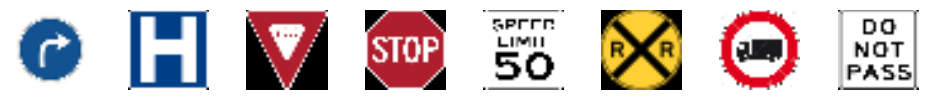

In [12]:
# Load images from image folder
import matplotlib.image as mpimg

def read_image(name):
    image = cv2.imread(name)
    image = cv2.resize(image, (32, 32))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255. # normalize the image
    return image

my_images = [read_image("./images/" + name) for name in os.listdir("./images/")]
my_images_labels = [name for name in os.listdir("./images/")]
my_images = np.array(my_images ,dtype = np.float32)

# Plot images
n_images = len(my_images)
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=.5)
for i in range(n_images):
    ax = plt.subplot(10, 10, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    plt.imshow(my_images[i])
    plt.axis('off')
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I downloaded 8 images from internet. some signs are US signs and some are common between german and US. I don't expect the prediction for US images be be correct because they are not in the german data.

In [20]:
# Predictions for my downloaded images
loader = tf.train.Saver()
file = 'trained_model.ckpt.meta'

top5 = tf.nn.top_k(prediction, 5)

print('Predictioning on downloaded images...')
with tf.Session() as sess:
    loader = tf.train.import_meta_graph(file)
    loader.restore(sess, tf.train.latest_checkpoint('.'))    
    prediction_top5 = sess.run([prediction, top5], feed_dict={x: my_images, keep_prob: 1.0})
print('Predictioning is complete')

Predictioning on downloaded images...
Predictioning is complete


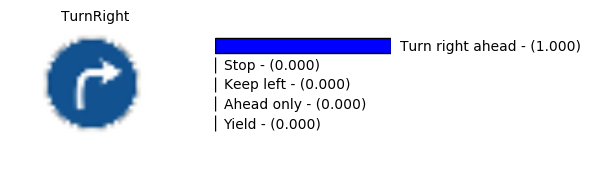

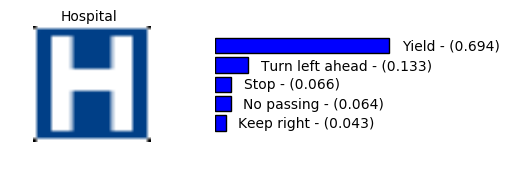

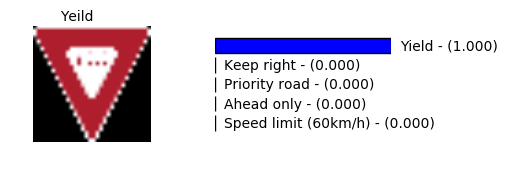

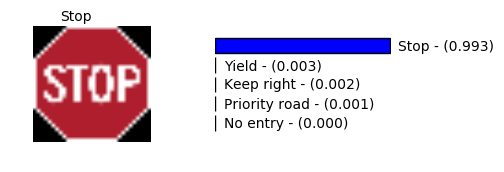

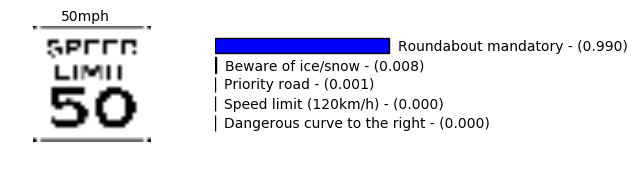

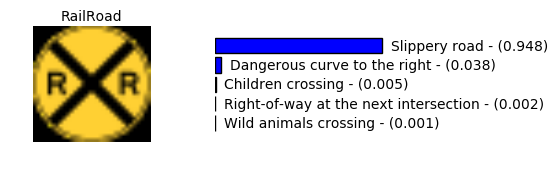

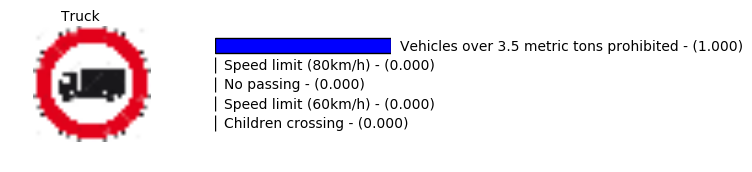

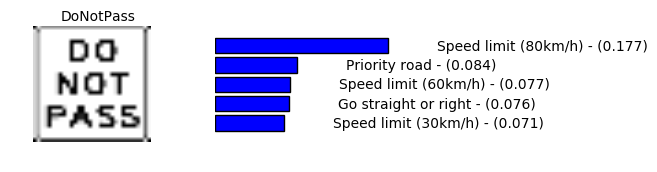

In [47]:
# Plot top 5 prediction for each downloaded image
classes = pd.read_csv('signnames.csv')
signNames = classes['SignName']
my_prediction = prediction_top5[1][0]
my_top5 = prediction_top5[1][1]

for i in range(len(my_images)):
    plt.figure(figsize = (5, 1.5))
    grid = gridspec.GridSpec(1, 2)

    plt.subplot(grid[0])
    plt.imshow(my_images[i])
    plt.text(7, -2, my_images_labels[i].split('.')[0]);
    plt.axis('off')
    
    plt.subplot(grid[1])
    plt.barh(6 - np.arange(5), my_prediction[i], align='center')
    plt.axis('off');
    
    for j in range(5):
        plt.text(my_prediction[i][j] + .05 , 6 - j - .25, signNames[my_top5[i][j]] + str(" - ({:.3f})".format(prediction_top5[1][0][i][j])))

    plt.show();

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The model performed poorely on US sign data. It performed well on signs that look like the signs in Germany (like stop, do not enter, etc). However, for signs that are significantly different from those seen in the training data set, generalization is poor.

In my test image signs, The **TurnRight, Yeild, Stop** signs have been classified correctly with high accuracy because the model have seen them already. The **Truck** sign is new and the network tried to classify it to nearest sign in german dataset. But The **Hospital, 50MPH, RailRoad, DoNotPass** haven't been classified correctly becuase they are new to the network.

All that said, the accuracy of the network is about 34.5%.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
The model is most certain of signs that are similar to signs in the training set (i.e. similar in Germany and USA). The model is very inaccurate for signs that are not similar to the signs in Germany. Also we should take image qualities into account. the lower quality, the less accuracy of the network.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.